<div align="center">
  <h1 style="color:#1976d2;"><b>Командная работа</b></h1>
  <p><b>По дисциплине: Машинное обучение и большие данные</b></p>
  <p><i>Мухитова Азалия, Каспранов Камиль — 22П-2</i></p>
</div>

### План выполнения работы

##### 1. Загрузка и первичный анализ данных

##### 2. Предобработка данных

##### 3. Визуализация данных

##### 4. Ансамблевые методы регрессии

#### 4. Ансамблевые методы классификации

#### 5. Оценка результатов

___

## 1. Загрузка и первичный анализ данных
В этом разделе происходит импорт библиотек, загрузка датасета и первичный просмотр структуры данных.

In [2]:
# Импорт необходимых библиотек
import pandas as pd
import string
import re
import numpy as np
import nltk
import pymorphy3
import matplotlib.pyplot as plt

In [3]:
df =pd.read_csv("real_estate_data.csv")

C:\Users\ROG\AppData\Local\Temp\ipykernel_22348\2539646407.py:1: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df =pd.read_csv("real_estate_data.csv")


In [4]:
df.head()

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,furnished,heating_type,price,price_currency
0,1,Konut,Rezidans,12/10/18,1/9/19,2,30,0,20 ve üzeri,2,2+1,90.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,3500.0,TRY
1,2,Konut,Daire,2/13/19,NaN,1,14,0,20 ve üzeri,20 ve üzeri,1+0,43.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,490000.0,TRY
2,3,Konut,Daire,10/9/18,11/8/18,1,30,0,1,Yüksek Giriş,2+1,NaN,Tekirdağ/Çorlu/Reşadiye,NaN,Fancoil,155000.0,TRY
3,4,Konut,Rezidans,9/10/18,10/10/18,1,30,3,20 ve üzeri,20 ve üzeri,6+1,450.0,İstanbul/Beşiktaş/Levent,NaN,Fancoil,32500000.0,TRY
4,5,Konut,Rezidans,12/10/18,1/9/19,1,30,0,20 ve üzeri,2,2+1,90.0,İstanbul/Kartal/Kordonboyu,NaN,Fancoil,1450000.0,TRY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403487 entries, 0 to 403486
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 403487 non-null  int64  
 1   type               403487 non-null  object 
 2   sub_type           403487 non-null  object 
 3   start_date         403487 non-null  object 
 4   end_date           266298 non-null  object 
 5   listing_type       403487 non-null  int64  
 6   tom                403487 non-null  int64  
 7   building_age       376097 non-null  object 
 8   total_floor_count  375466 non-null  object 
 9   floor_no           368191 non-null  object 
 10  room_count         403487 non-null  object 
 11  size               257481 non-null  float64
 12  address            403487 non-null  object 
 13  furnished          0 non-null       float64
 14  heating_type       375517 non-null  object 
 15  price              402772 non-null  float64
 16  pr

В датасете 403487 записей и 17 столбцов.
Большинство признаков заполнены, но есть пропуски.
Столбец furnished полностью пустой и не несёт информации.
Данные содержат как числовые, так и категориальные признаки.

___

### Описание структуры датасета недвижимости

| № | Столбец | Описание |
|---|---------|----------|
| 1 | `id` | Уникальный идентификатор объекта недвижимости |
| 2 | `type` | Тип свойства: `Konut` (Жилье) |
| 3 | `sub_type` | Подтип свойства: `Daire` (Квартира), `Rezidans` (Жилой комплекс) |
| 4 | `start_date` | Дата начала активности объявления |
| 5 | `end_date` | Дата окончания активности объявления (если применимо) |
| 6 | `listing_type` | Тип листинга: `1` - Продажа, `2` - Аренда |
| 7 | `tom` | Время на рынке (в днях) |
| 8 | `building_age` | Возраст здания (текстовое описание) |
| 9 | `total_floor_count` | Общее количество этажей в здании |
| 10 | `floor_no` | Номер этажа объекта |
| 11 | `room_count` | Количество комнат (формат: "2+1") |
| 12 | `size` | Площадь объекта в м² |
| 13 | `address` | Адрес объекта (город/район/окружение) |
| 14 | `furnished` | Меблировка (всегда пусто) |
| 15 | `heating_type` | Тип отопления |
| 16 | `price` | Цена объекта |
| 17 | `price_currency` | Валюта цены: `TRY`, `USD`, `EUR` |

___

## 2. Предобработка данных
В этом разделе реализована очистка, парсинг и преобразование признаков, а также обработка пропусков.

In [6]:
# Удаление полностью пустой колонки
df.drop(columns=['furnished'], inplace=True, errors='ignore')

In [7]:
# Обработка текстовых полей
def parse_room_count(room_str):
    """Парсинг формата комнат: 2+1, 3+1 и т.д."""
    if pd.isna(room_str):
        return np.nan
    
    room_str = str(room_str).strip()
    # Ищем паттерн типа "2+1", "3+1" и т.д.
    match = re.search(r'(\d+)\s*\+\s*(\d+)', room_str)
    if match:
        rooms = int(match.group(1))
        living_rooms = int(match.group(2))
        return rooms + living_rooms  # Общее количество комнат
    else:
        # Пробуем извлечь просто число
        try:
            return float(room_str)
        except:
            return np.nan

def parse_floor(floor_str):
    """Парсинг информации о этаже"""
    if pd.isna(floor_str):
        return np.nan
    
    floor_str = str(floor_str).strip().lower()
    
    # Специальные случаи этажей
    special_floors = {
        'yüksek giriş': 1,  # 1-й этаж
        'giriş kat': 0, 'kot1': 0, 'zemin kat': 0,  # цокольный этаж
        'çatı katı': -1,  # этаж крыши (последний)
        'bahçe katı': -2   # нулевой этаж/этаж с выходом в сад
    }
    
    for key, value in special_floors.items():
        if key in floor_str:
            return value
    
    # Пробуем извлечь числовое значение
    try:
        return float(re.search(r'\d+', floor_str).group())
    except:
        return np.nan

def parse_building_age(age_str):
    """Парсинг возраста здания"""
    if pd.isna(age_str):
        return np.nan
    
    age_str = str(age_str).strip().lower()
    
    # Специальные категории
    if 'sıfır' in age_str or '0' in age_str:
        return 0  # Новостройка
    elif '1-5' in age_str or '1 ile 5' in age_str:
        return 3  # Среднее значение диапазона
    elif '6-10' in age_str:
        return 8
    elif '11-15' in age_str:
        return 13
    elif '16-20' in age_str:
        return 18
    elif '20+' in age_str or '21' in age_str:
        return 25  # Приблизительное значение для старых зданиях
    else:
        # Пробуем извлечь конкретное число
        try:
            return float(re.search(r'\d+', age_str).group())
        except:
            return np.nan

In [8]:
# Применяем методы к текстовым полям
df['room_count'] = df['room_count'].apply(parse_room_count)
df['floor_no'] = df['floor_no'].apply(parse_floor)
df['building_age_numeric'] = df['building_age'].apply(parse_building_age)

In [9]:
df.head()

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,heating_type,price,price_currency,building_age_numeric
0,1,Konut,Rezidans,12/10/18,1/9/19,2,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,3500.0,TRY,0.0
1,2,Konut,Daire,2/13/19,NaN,1,14,0,20 ve üzeri,20.0,1.0,43.0,İstanbul/Kartal/Kordonboyu,Fancoil,490000.0,TRY,0.0
2,3,Konut,Daire,10/9/18,11/8/18,1,30,0,1,1.0,3.0,NaN,Tekirdağ/Çorlu/Reşadiye,Fancoil,155000.0,TRY,0.0
3,4,Konut,Rezidans,9/10/18,10/10/18,1,30,3,20 ve üzeri,20.0,7.0,450.0,İstanbul/Beşiktaş/Levent,Fancoil,32500000.0,TRY,3.0
4,5,Konut,Rezidans,12/10/18,1/9/19,1,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,1450000.0,TRY,0.0


In [10]:
# Обработка пропущенных значений
# Для числовых признаков
numeric_cols = ['size', 'price', 'room_count', 'floor_no', 'building_age_numeric']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# Для категориальных признаков
categorical_cols = ['heating_type', 'price_currency', 'building_age']
for col in categorical_cols:
    if col in df.columns:
        df[col].fillna('Unknown', inplace=True)

# Для дат
df['end_date'].fillna('Active', inplace=True)  # Активные объявления

C:\Users\ROG\AppData\Local\Temp\ipykernel_22348\1207355733.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\ROG\AppData\Local\Temp\ipykernel_22348\1207355733.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [11]:
# Преобразование типов данных
# Дата-время
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Категориальные переменные с учетом турецких значений
categorical_mappings = {
    'type': {'Konut': 'Housing'},
    'sub_type': {'Daire': 'Flat'},
    'listing_type': {1: 'Sale', 2: 'Rent'},
    'price_currency': {'TL': 'TRY', 'USD': 'USD', 'EUR': 'EUR'}
}

for col, mapping in categorical_mappings.items():
    if col in df.columns:
        df[col] = df[col].replace(mapping)
        df[col] = df[col].astype('category')

C:\Users\ROG\AppData\Local\Temp\ipykernel_22348\3343624910.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
C:\Users\ROG\AppData\Local\Temp\ipykernel_22348\3343624910.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')


In [12]:
df.head()

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,heating_type,price,price_currency,building_age_numeric
0,1,Housing,Rezidans,2018-12-10,2019-01-09,Rent,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,3500.0,TRY,0.0
1,2,Housing,Flat,2019-02-13,NaT,Sale,14,0,20 ve üzeri,20.0,1.0,43.0,İstanbul/Kartal/Kordonboyu,Fancoil,490000.0,TRY,0.0
2,3,Housing,Flat,2018-10-09,2018-11-08,Sale,30,0,1,1.0,3.0,110.0,Tekirdağ/Çorlu/Reşadiye,Fancoil,155000.0,TRY,0.0
3,4,Housing,Rezidans,2018-09-10,2018-10-10,Sale,30,3,20 ve üzeri,20.0,7.0,450.0,İstanbul/Beşiktaş/Levent,Fancoil,32500000.0,TRY,3.0
4,5,Housing,Rezidans,2018-12-10,2019-01-09,Sale,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,1450000.0,TRY,0.0


In [ ]:
# Создаём новый признак - Время на рынке в днях
if 'start_date' in df.columns:
    current_date = pd.Timestamp.now()
    df['days_on_market'] = (current_date - df['start_date']).dt.days
    df['days_on_market'].fillna(df['days_on_market'].median(), inplace=True)

C:\Users\ROG\AppData\Local\Temp\ipykernel_22348\533421397.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_on_market'].fillna(df['days_on_market'].median(), inplace=True)


###### В ходе предобработки данных были созданы новые признаки:

###### - **days_on_market** — количество дней, сколько объект находится на рынке. Этот признак помогает анализировать ликвидность недвижимости и выявлять объекты, которые долго не продаются или не сдаются.

###### - **building_age_numeric** — числовое представление возраста здания, полученное из текстового описания. Упрощает анализ зависимости цены от возраста недвижимости.

###### - **room_count** — общее количество комнат, преобразованное из формата "2+1" в число.

###### - **total_floor_count, floor_no** — числовые признаки, отражающие этажность здания и номер этажа, что важно для оценки привлекательности и стоимости объекта.

In [14]:
# Удаляем выбросы в столбце "price", учитывая тип недвижимости.
def remove_price_outliers(df):
    """Удаление выбросов в цене с учетом типа недвижимости"""
    if 'price' not in df.columns or 'sub_type' not in df.columns:
        return df
    
    # Убираем явно ошибочные значения
    df = df[df['price'] > 100]  # Минимальная цена

        # Убираем крайние выбросы по квартирному типу
    if 'Flat' in df['sub_type'].values:
        flat_mask = df['sub_type'] == 'Flat'
        df_flat = df[flat_mask]
        if len(df_flat) > 0:
            Q1 = df_flat['price'].quantile(0.01)
            Q3 = df_flat['price'].quantile(0.99)
            df = df[~flat_mask | ((df['price'] >= Q1) & (df['price'] <= Q3))]
    
    return df

In [15]:
df = remove_price_outliers(df)

In [16]:
df.head()

,id,type,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,address,heating_type,price,price_currency,building_age_numeric,days_on_market
0,1,Housing,Rezidans,2018-12-10,2019-01-09,Rent,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,3500.0,TRY,0.0,2459
1,2,Housing,Flat,2019-02-13,NaT,Sale,14,0,20 ve üzeri,20.0,1.0,43.0,İstanbul/Kartal/Kordonboyu,Fancoil,490000.0,TRY,0.0,2394
2,3,Housing,Flat,2018-10-09,2018-11-08,Sale,30,0,1,1.0,3.0,110.0,Tekirdağ/Çorlu/Reşadiye,Fancoil,155000.0,TRY,0.0,2521
3,4,Housing,Rezidans,2018-09-10,2018-10-10,Sale,30,3,20 ve üzeri,20.0,7.0,450.0,İstanbul/Beşiktaş/Levent,Fancoil,32500000.0,TRY,3.0,2550
4,5,Housing,Rezidans,2018-12-10,2019-01-09,Sale,30,0,20 ve üzeri,2.0,3.0,90.0,İstanbul/Kartal/Kordonboyu,Fancoil,1450000.0,TRY,0.0,2459


In [17]:
df['sub_type'].unique()

['Rezidans', 'Flat', 'Villa', 'Müstakil Ev', 'Kooperatif', ..., 'Prefabrik Ev', 'Köşk / Konak / Yalı', 'Çiftlik Evi', 'Yalı Dairesi', 'Loft']
Length: 12
Categories (12, object): ['Flat', 'Komple Bina', 'Kooperatif', 'Köşk / Konak / Yalı', ..., 'Villa', 'Yalı Dairesi', 'Yazlık', 'Çiftlik Evi']

In [ ]:
# Преобразовываем sub_type (тип здания) в числовые значения
sub_type_mapping = {value: idx for idx, value in enumerate(df['sub_type'].unique())}
df['sub_type'] = df['sub_type'].map(sub_type_mapping)
df['sub_type'] = df['sub_type'].astype(int)

In [19]:
df['type'].unique()

['Housing']
Categories (1, object): ['Housing']

In [20]:
df['listing_type'].unique()

['Rent', 'Sale', 3]
Categories (3, object): [3, 'Rent', 'Sale']

In [21]:
df = df[df['listing_type'] != 3]

In [22]:
# Создаем словарь для преобразования
listing_type_mapping = {
    'Rent': 0,
    'Sale': 1
}

# Преобразуем колонку в числовой формат
df['listing_type'] = df['listing_type'].map(listing_type_mapping)

In [23]:
# Исходный массив
heating_types = np.array(['Fancoil', 'Yok', 'Kalorifer (Doğalgaz)', 'Kalorifer (Kömür)',
       'Kombi (Elektrikli)', 'Klima', 'Kombi (Doğalgaz)',
       'Merkezi Sistem (Isı Payı Ölçer)', 'Merkezi Sistem',
       'Soba (Kömür)', 'Yerden Isıtma', 'Soba (Doğalgaz)',
       'Güneş Enerжisi', 'Kalorifer (Akaryakıt)', 'Jeotermal',
       'Kat Kaloriferi'], dtype=object)

# Создаем словарь для преобразования
heating_mapping = {
    'Yok': 0,
    'Soba (Kömür)': 1,
    'Soba (Doğalgaz)': 2,
    'Kalorifer (Kömür)': 3,
    'Kalorifer (Doğalgaz)': 4,
    'Kalorifer (Akaryakıt)': 5,
    'Kombi (Doğalgaz)': 6,
    'Kombi (Elektrikli)': 7,
    'Kat Kaloriferi': 8,
    'Merkezi Sistem': 9,
    'Merkezi Sistem (Isı Payı Ölçer)': 10,
    'Yerden Isıtma': 11,
    'Klima': 12,
    'Fancoil': 13,
    'Güneş Enerжisi': 14,
    'Jeotermal': 15
}

# Преобразование массива в числовой формат
numeric_values = np.array([heating_mapping.get(item, -1) for item in heating_types])

df['heating_type'] = df['heating_type'].map(heating_mapping)

In [24]:
# Извлекаем первое число из строки, возвращаем NaN если не получается
def parse_total_floor_count(val):
    if pd.isna(val): return np.nan
    try:
        return int(re.search(r'\d+', str(val)).group())
    except:
        return np.nan

if 'total_floor_count' in df.columns:
    df['total_floor_count'] = df['total_floor_count'].apply(parse_total_floor_count)
    df['total_floor_count'].fillna(df['total_floor_count'].median(), inplace=True)

C:\Users\ROG\AppData\Local\Temp\ipykernel_22348\1504281391.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_floor_count'].fillna(df['total_floor_count'].median(), inplace=True)


In [26]:
# Проверка пропусков и базовая статистика
print('Пропуски по столбцам:')
print(df.isnull().sum())

Пропуски по столбцам:
id                           0
type                         0
sub_type                     0
start_date                   0
end_date                134170
listing_type                 0
tom                          0
building_age                 0
total_floor_count            0
floor_no                     0
room_count                   0
size                         0
address                      0
heating_type             28888
price                        0
price_currency               0
building_age_numeric         0
days_on_market               0
dtype: int64


In [27]:
# Переводим все цены к единой валюте TRY
def convert_to_try(row):
    if row['price_currency'] == 'EUR':
        return round(row['price'] * 48, 2)
    elif row['price_currency'] == 'USD':
        return round(row['price'] * 41, 2)
    else:
        return round(row['price'], 2)

if 'price_currency' in df.columns and 'price' in df.columns:
    df['price'] = df.apply(convert_to_try, axis=1)
    df['price_currency'] = 'TRY'  # Обновляем столбец валюты

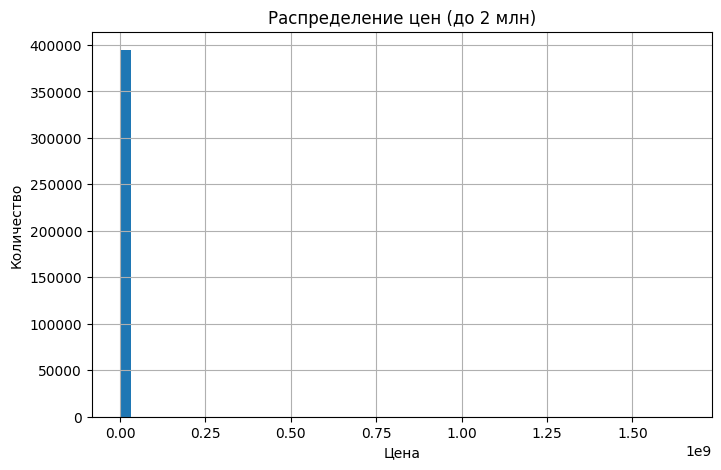

In [ ]:
# Визуализация распределения цен с ограничением
plt.figure(figsize=(8,5))
df[df['price'] < 2000000]['price'].hist(bins=50)
plt.title('Распределение цен (до 2 млн)')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

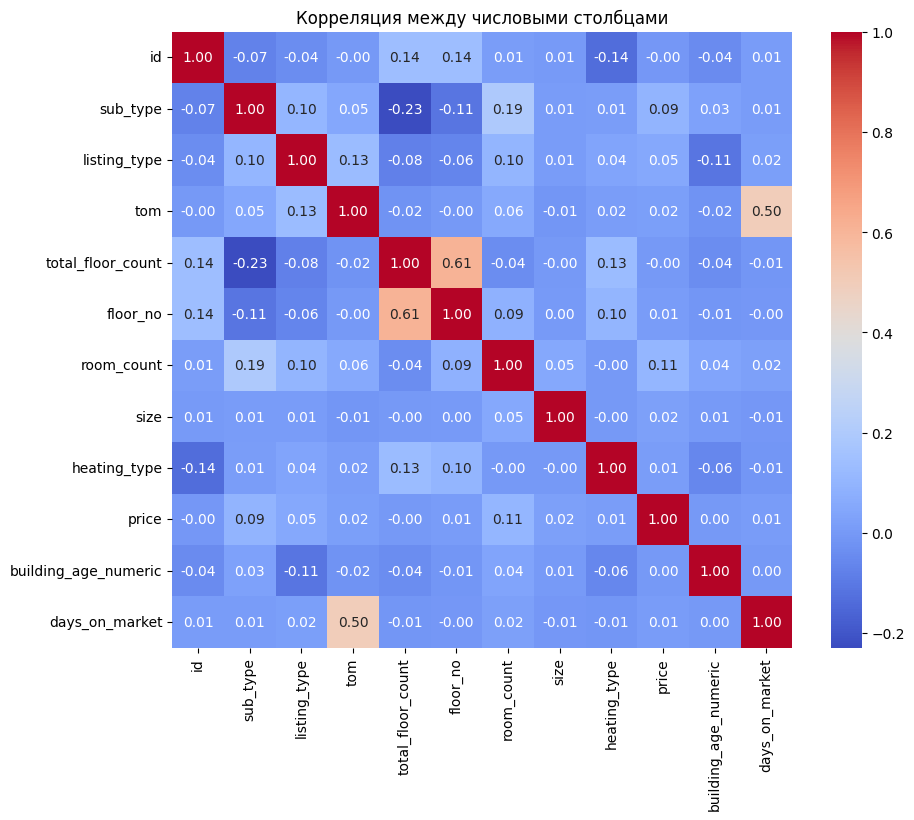

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Выбираем только числовые столбцы
numeric_cols = df.select_dtypes(include='number')

# Строим корреляционную матрицу
corr_matrix = numeric_cols.corr()

# Визуализируем тепловую карту
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляция между числовыми столбцами')
plt.show()

Видна корреляция между столбцами Days_omn_market и tom.И между floor_no и total_floor_count.

In [35]:
# Удаляем ненужные столбцы
drop_cols = [
    'id', 'address', 'start_date', 'end_date', 'tom', 'building_age',
    'type', 'price_currency', 'furnished'
]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
df.head()

,sub_type,listing_type,total_floor_count,floor_no,room_count,size,heating_type,price,building_age_numeric,days_on_market
0,0,0.0,20.0,2.0,3.0,90.0,13.0,3500.0,0.0,2459
1,1,1.0,20.0,20.0,1.0,43.0,13.0,490000.0,0.0,2394
2,1,1.0,1.0,1.0,3.0,110.0,13.0,155000.0,0.0,2521
3,0,1.0,20.0,20.0,7.0,450.0,13.0,32500000.0,3.0,2550
4,0,1.0,20.0,2.0,3.0,90.0,13.0,1450000.0,0.0,2459


###### Удаляем именно эти столбцы, потому что они не несут полезной информации для дальнейшего анализа.

In [36]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Для каждой числовой колонки заменяем 'Unknown' на медиану
for column in numeric_columns:
    # Находим медиану только для нормальных значений (не 'Unknown')
    median_value = df[df[column].astype(str) != 'Unknown'][column].median()
    
    # Заменяем 'Unknown' на медиану
    df.loc[df[column].astype(str) == 'Unknown', column] = median_value

In [37]:
# Заменяем все NaN на медианные значения по столбцам
df = df.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in 'biufc' else x)

In [38]:
# Для понятного отображения данных
pd.options.display.float_format = '{:.1f}'.format

In [39]:
df.describe()

,sub_type,listing_type,total_floor_count,floor_no,room_count,size,heating_type,price,building_age_numeric,days_on_market
count,394822.0,394822.0,394822.0,394822.0,394822.0,394822.0,394822.0,394822.0,394822.0,394822.0
mean,1.2,0.7,5.2,2.8,3.7,213.3,7.4,394006.6,3.1,2481.3
std,0.9,0.4,3.1,2.9,1.1,7197.6,2.8,4919649.0,6.7,50.5
min,0.0,0.0,1.0,-2.0,0.0,1.0,0.0,129.0,0.0,2380.0
25%,1.0,0.0,3.0,1.0,3.0,100.0,6.0,2950.0,0.0,2443.0
50%,1.0,1.0,4.0,2.0,4.0,110.0,6.0,200000.0,0.0,2487.0
75%,1.0,1.0,6.0,4.0,4.0,124.0,10.0,340000.0,3.0,2525.0
max,11.0,1.0,20.0,20.0,20.0,948235.0,15.0,1650000000.0,31.0,2560.0


In [40]:
# Удаляем выбросы с помощью ограничений по процентилям
# По price 
Q1 = df['price'].quantile(0.01)
Q3 = df['price'].quantile(0.99)
df = df[(df['price'] >= Q1) & (df['price'] <= Q3)]

# По size
q_low_size = df['size'].quantile(0.01)
q_high_size = df['size'].quantile(0.99)

df = df[(df['size'] >= q_low_size) & (df['size'] <= q_high_size)]

In [41]:
df.describe()

,sub_type,listing_type,total_floor_count,floor_no,room_count,size,heating_type,price,building_age_numeric,days_on_market
count,381940.0,381940.0,381940.0,381940.0,381940.0,381940.0,381940.0,381940.0,381940.0,381940.0
mean,1.2,0.7,5.2,2.8,3.7,115.1,7.4,250906.3,3.1,2481.6
std,0.8,0.4,3.0,2.9,1.0,35.6,2.8,290136.1,6.7,50.6
min,0.0,0.0,1.0,-2.0,1.0,45.0,0.0,600.0,0.0,2380.0
25%,1.0,0.0,3.0,1.0,3.0,100.0,6.0,2900.0,0.0,2443.0
50%,1.0,1.0,4.0,2.0,4.0,110.0,6.0,200000.0,0.0,2488.0
75%,1.0,1.0,6.0,4.0,4.0,120.0,10.0,330000.0,3.0,2525.0
max,11.0,1.0,20.0,20.0,20.0,305.0,15.0,2750000.0,31.0,2560.0


Удаление выбросов значительно улучшило качество данных.

___

### 3. Визуализация оставшихся столбцов

In [42]:
df.columns

Index(['sub_type', 'listing_type', 'total_floor_count', 'floor_no',
       'room_count', 'size', 'heating_type', 'price', 'building_age_numeric',
       'days_on_market'],
      dtype='object')

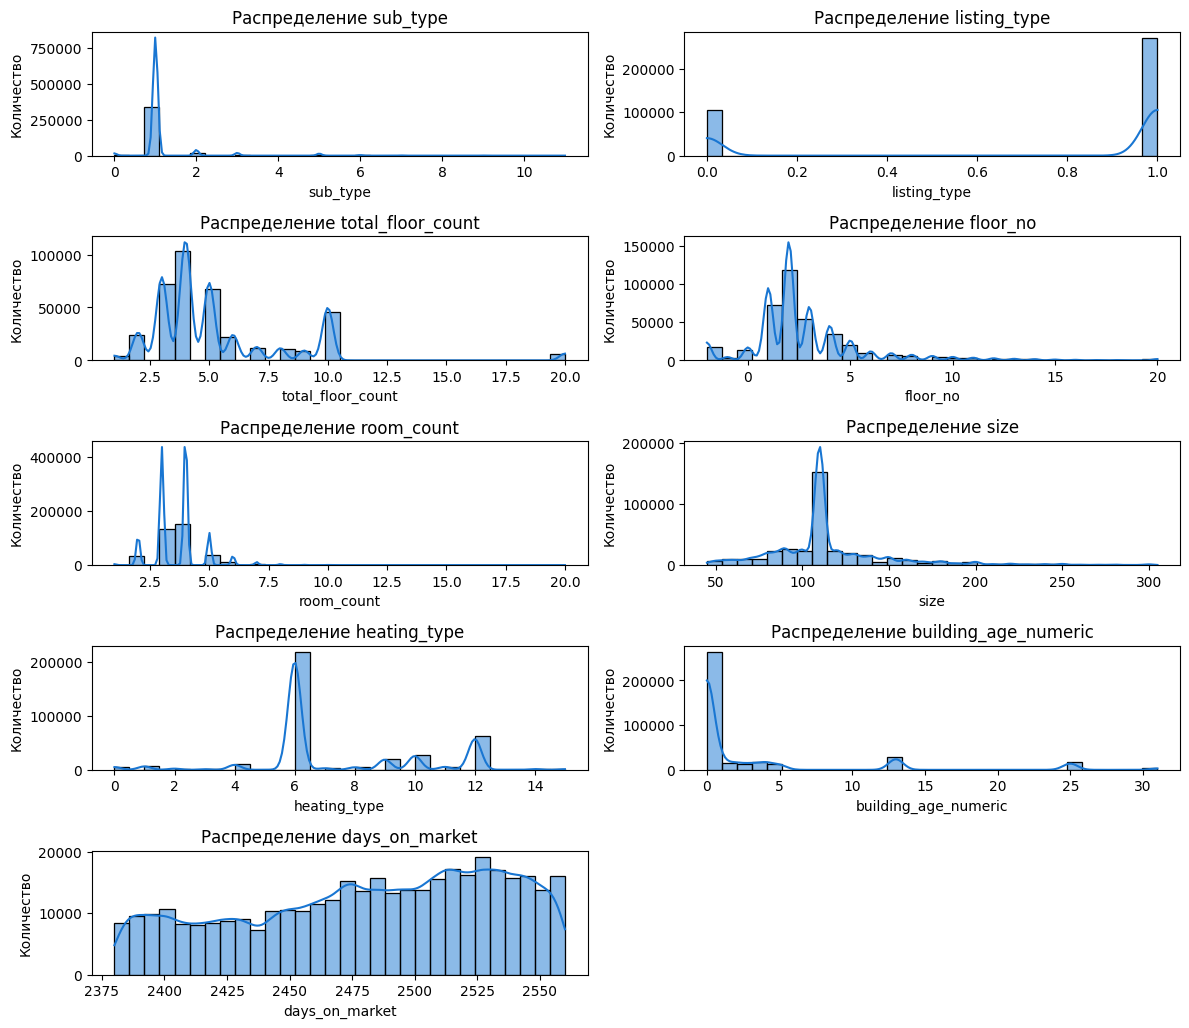

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['sub_type', 'listing_type', 'total_floor_count', 'floor_no',
       'room_count', 'size', 'heating_type', 'price', 'building_age_numeric',
       'days_on_market']

plt.figure(figsize=(12, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(6, 2, i)
    sns.histplot(df[col], bins=30, kde=True, color='#1976d2')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
plt.tight_layout()
plt.show()

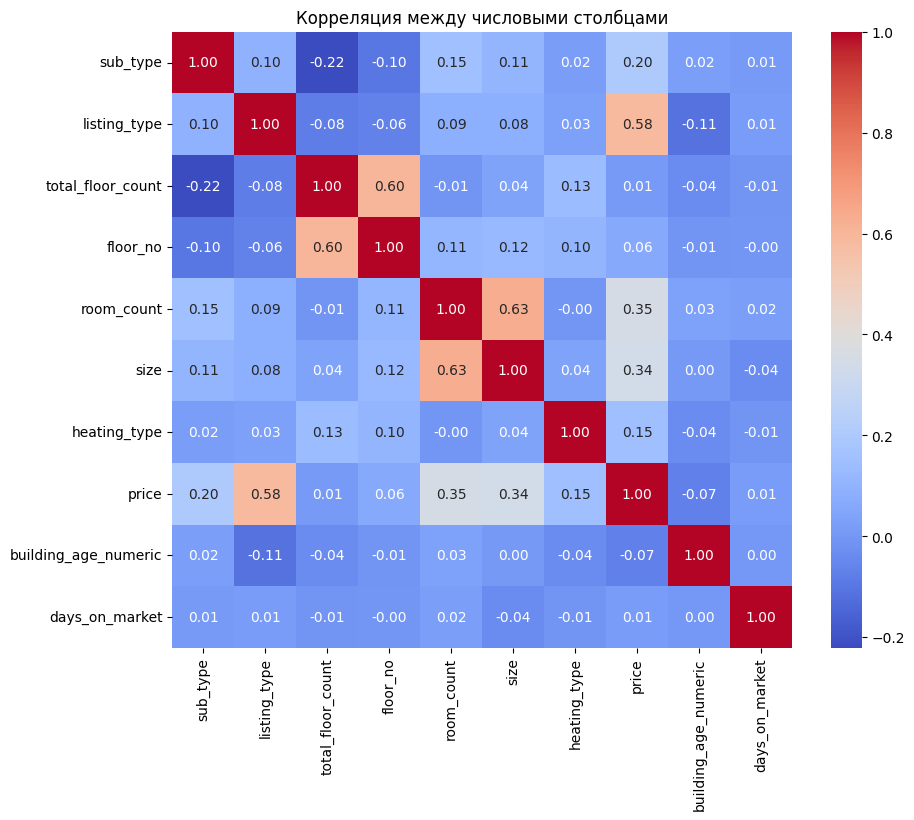

In [132]:
numeric_cols = df.select_dtypes(include='number')

# Строим корреляционную матрицу
corr_matrix = numeric_cols.corr()

# Визуализируем тепловую карту
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляция между числовыми столбцами')
plt.show()

Видна хорошая корреляция между price и listing_type (0.58). size и room_count (0.63). floor_no и total_floor_count (0.60)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381940 entries, 0 to 403486
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   sub_type              381940 non-null  int64  
 1   listing_type          381940 non-null  float64
 2   total_floor_count     381940 non-null  float64
 3   floor_no              381940 non-null  float64
 4   room_count            381940 non-null  float64
 5   size                  381940 non-null  float64
 6   heating_type          381940 non-null  float64
 7   price                 381940 non-null  float64
 8   building_age_numeric  381940 non-null  float64
 9   days_on_market        381940 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 32.1 MB


После очищения датасета у нас осталось 381940 записей и 9 столбцов.
Теперь нет ни одного пропущенного значения во всех столбцах.

___

### 4. Ансамблевые методы регрессии

In [153]:
# Импортируем необходимые библиотеки
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.discriminant_analysis import StandardScaler

# Подготовка данных для моделирования
# Выбираем целевую переменную и признаки
X = df[['sub_type', 'listing_type', 'total_floor_count', 'floor_no',
       'room_count', 'size', 'heating_type', 'building_age_numeric',
       'days_on_market']]
y = df['price'].copy()

mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (251109, 9)
Размер тестовой выборки: (123682, 9)


In [154]:
# Создание BaggingRegressor с базовыми моделями Random Forest
bagging_rf = BaggingRegressor(
    estimator=RandomForestRegressor(n_estimators=10, random_state=42),
    n_estimators=5,
    random_state=42,
    n_jobs=1
)

# Обучение модели
print("Обучение BaggingRegressor...")
bagging_rf.fit(X_train, y_train)

# Предсказания
y_pred_bagging = bagging_rf.predict(X_test)

# Оценка качества
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
rmse_bagging = np.sqrt(mse_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)

print(f"\n=== BaggingRegressor (Random Forest) ===")
print(f"MSE: {mse_bagging:.2f}")
print(f"RMSE: {rmse_bagging:.2f}")
print(f"MAE: {mae_bagging:.2f}")
print(f"R²: {r2_bagging:.4f}")

Обучение BaggingRegressor...

=== BaggingRegressor (Random Forest) ===
MSE: 19395683232.97
RMSE: 139268.39
MAE: 74283.24
R²: 0.6945


Модель BaggingRegressor показывает достойное качество для предсказания цен недвижимости. Значение R² близко к 0.7 — это признак того, что модель хорошо справляется с задачей.

In [156]:
# Создание AdaBoostRegressor
from sklearn.discriminant_analysis import StandardScaler


adaboost = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Обучение модели
print("Обучение AdaBoostRegressor...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Оценка качества
mse_adaboost = mean_squared_error(y_test, y_pred_adaboost)
rmse_adaboost = np.sqrt(mse_adaboost)
r2_adaboost = r2_score(y_test, y_pred_adaboost)
mae_adaboost = mean_absolute_error(y_test, y_pred_adaboost)

print(f"\n=== AdaBoostRegressor ===")
print(f"MSE: {mse_adaboost:.2f}")
print(f"RMSE: {rmse_adaboost:.2f}")
print(f"MAE: {mae_adaboost:.2f}")
print(f"R²: {r2_adaboost:.4f}")

Обучение AdaBoostRegressor...

=== AdaBoostRegressor ===
MSE: 36061507043.79
RMSE: 189898.68
MAE: 129791.25
R²: 0.4320


AdaBoostRegressor работает хуже. Ошибки выше, а объяснённая дисперсия ниже. Для нашей задачи BaggingRegressor оказался более подходящим

In [151]:
# Создание StackingRegressor
# Определяем базовые модели
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('bagging', BaggingRegressor(n_estimators=10, random_state=42)),
    ('adaboost', AdaBoostRegressor(n_estimators=50, learning_rate=0.1, random_state=42))
]

# Создаем стекинг модель
stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

# Обучение модели
print("Обучение StackingRegressor...")
stacking.fit(X_train, y_train)

# Предсказания
y_pred_stacking = stacking.predict(X_test)

# Оценка качества
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)

print(f"\n=== StackingRegressor ===")
print(f"MSE: {mse_stacking:.2f}")
print(f"RMSE: {rmse_stacking:.2f}")
print(f"MAE: {mae_stacking:.2f}")
print(f"R²: {r2_stacking:.4f}")

Обучение StackingRegressor...

=== StackingRegressor ===
MSE: 18748229366.02
RMSE: 136924.17
MAE: 71999.91
R²: 0.7047


StackingRegressor показывает наилучшее качество - ошибки минимальны, а объяснённая дисперсия максимальна.

**Вывод по ансамблевым моделям регрессии:**

BaggingRegressor (Random Forest):
Хорошее качество, R² ≈ 0.69, ошибки ниже, чем у AdaBoost.
Подходит для задачи, но не лучший результат.

AdaBoostRegressor:
Качество заметно хуже, R² ≈ 0.43, ошибки значительно выше.

StackingRegressor:
Лучшее качество, R² ≈ 0.70, минимальные ошибки среди всех моделей.
Наиболее эффективная модель для предсказания цены недвижимости.

Итог:
Лучше всего работает StackingRegressor — он обеспечивает максимальную точность и минимальные ошибки.

___

### 6. Ансамблевые методы класификации

In [158]:
### Классификация по типу недвижимости
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler 

# Подготовка данных
# Признаки
X = df[['total_floor_count', 'floor_no', 'room_count', 'size', 'building_age_numeric', 
        'days_on_market', 'price']].copy()

# Целевая переменная - тип недвижимости
y = df['sub_type'].copy()

# Удаление строк с пропущенными значениями
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Распределение классов в обучающей выборке:")
print(y_train.value_counts())

Размер обучающей выборки: (251109, 7)
Размер тестовой выборки: (123682, 7)
Распределение классов в обучающей выборке:
sub_type
1     225336
2      10774
3       5209
0       4200
5       3835
6        986
7        354
9        196
10        84
8         71
4         44
11        20
Name: count, dtype: int64


In [159]:
# 1. Bagging Classifier
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

bagging_clf.fit(X_train_scaled, y_train)
y_pred_bagging = bagging_clf.predict(X_test_scaled)

print("=== Bagging Classifier ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bagging))

=== Bagging Classifier ===
Accuracy: 0.9388

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.46      0.54      2069
           1       0.97      0.98      0.97    110987
           2       0.70      0.71      0.71      5307
           3       0.61      0.45      0.52      2566
           4       0.73      0.38      0.50        21
           5       0.57      0.38      0.45      1889
           6       0.61      0.34      0.44       486
           7       0.82      0.78      0.80       174
           8       0.74      0.40      0.52        35
           9       0.52      0.23      0.32        97
          10       0.75      0.36      0.48        42
          11       0.00      0.00      0.00         9

    accuracy                           0.94    123682
   macro avg       0.64      0.46      0.52    123682
weighted avg       0.93      0.94      0.93    123682



 Модель эффективна только для идентификации основного класса (1). Для практического применения она непригодна для прогнозирования миноритарных классов.

In [160]:
# 2. AdaBoost Classifier
adaboost_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

adaboost_clf.fit(X_train_scaled, y_train)
y_pred_adaboost = adaboost_clf.predict(X_test_scaled)

print("=== AdaBoost Classifier ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adaboost):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adaboost))

=== AdaBoost Classifier ===
Accuracy: 0.9058

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2069
           1       0.91      1.00      0.95    110987
           2       0.54      0.26      0.35      5307
           3       0.00      0.00      0.00      2566
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00      1889
           6       0.00      0.00      0.00       486
           7       0.00      0.00      0.00       174
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00        97
          10       0.00      0.00      0.00        42
          11       0.00      0.00      0.00         9

    accuracy                           0.91    123682
   macro avg       0.12      0.10      0.11    123682
weighted avg       0.84      0.91      0.87    123682



c:\Users\ROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Модель непригодна для практического использования в многоклассовой классификации, так как она не умеет предсказывать редкие типы недвижимости.

In [161]:
# 3. Stacking Classifier
base_classifiers = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('bagging', BaggingClassifier(n_estimators=10, random_state=42)),
    ('adaboost', AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(random_state=42),cv=5,n_jobs=-1)

stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_test_scaled)

print("=== Stacking Classifier ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stacking))

=== Stacking Classifier ===
Accuracy: 0.9452

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.44      0.57      2069
           1       0.96      0.99      0.98    110987
           2       0.71      0.74      0.73      5307
           3       0.69      0.47      0.56      2566
           4       0.00      0.00      0.00        21
           5       0.66      0.37      0.48      1889
           6       0.77      0.35      0.48       486
           7       0.84      0.80      0.82       174
           8       0.93      0.40      0.56        35
           9       0.68      0.24      0.35        97
          10       1.00      0.21      0.35        42
          11       0.00      0.00      0.00         9

    accuracy                           0.95    123682
   macro avg       0.67      0.42      0.49    123682
weighted avg       0.94      0.95      0.94    123682



c:\Users\ROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Stacking Classifier — это наиболее мощная и точная модель, что видно по общему Accuracy и метрике R² в задаче регрессии.Но также имеет проблемы с определением других классов.

## Сохранение моделей

In [81]:
import pickle

# Сохранение моделей регресси
with open('stacking_regressor_model.pkl', 'wb') as f:
    pickle.dump(stacking, f)

# Сохранение моделей классификации
with open('stacking_classifier_model.pkl', 'wb') as f:
    pickle.dump(stacking_clf, f)

print("Все модели успешно сохранены.")

Все модели успешно сохранены.


### Вывод по проделанной работе

В ходе проекта был проведен комплексный анализ данных о недвижимости и реализованы модели машинного обучения для решения двух ключевых задач: регрессии (прогнозирование цены) и классификации (определение типа недвижимости).

1. Предобработка данных
 Очищено 403 тыс. записей, удалены аномалии, обработаны пропуски, преобразованы категориальные признаки. Финальный датасет: 382 тыс. объектов.

2. Регрессия (прогноз цены)
 StackingRegressor показал лучший результат (R² = 0.70, MAE = 72к). Модель готова к использованию.

3. Классификация (тип недвижимости)
Выявлена критическая проблема - экстремальный дисбаланс классов. Модели идеально предсказывают квартиры (97% точности), но игнорируют редкие типы недвижимости. Высокий Accuracy (94-95%) обманчив.